In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import multiprocessing
import multiprocessing as mp
from time import time
from multiprocessing import Queue
print("Number of cpu : ", multiprocessing.cpu_count())

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=128)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

import sys 
sys.path.append('..')
from time import time
from circuit_generate import generate_circuit_paper, generate_circuit_2local, generate_circuit_2local_swap

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("darkgrid")

Number of cpu :  12


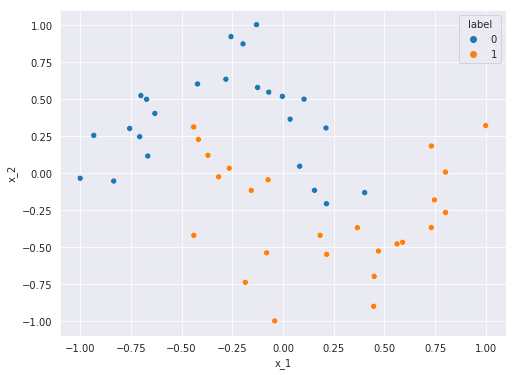

In [2]:
### Moonshape data
X,y = datasets.make_moons(n_samples=50, noise=0.2, random_state=7)

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

plt.figure(figsize=(8,6))
data_df = pd.DataFrame(dict(x_1=X[:,0], x_2=X[:,1], label=y))
sns.scatterplot('x_1', 'x_2', data=data_df, hue='label')
plt.show()

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state = 10,test_size=1/5)

##### Parameter

In [3]:
MODE = "2local" # paper、2local、2local_swap

QUBIT = 2
FEATURE = 2
BIT = 5 if MODE == "paper" else 6

GENE = 10
POPULATION = multiprocessing.cpu_count() # 12

POOLSIZE = 4
OFFSPRINGSIZE = POPULATION - POOLSIZE

PROB = 8
MUTATION_PROB = PROB/GENE

GENERATION = 200
EARLYSTOP = 20

##### Multi-task QSVM

In [4]:
def task(i, pop, q, mode):
    if mode == "paper": qc_i, r_i, h_i, cnot_i = generate_circuit_paper(pop[i], QUBIT, FEATURE)
    elif mode == "2local": qc_i, r_i, h_i, cnot_i = generate_circuit_2local(pop[i], QUBIT, FEATURE)
    elif mode == "2local_swap": qc_i, r_i, h_i, cnot_i, swap_i = generate_circuit_2local_swap(pop[i], QUBIT, FEATURE)
    kernel = QuantumKernel(feature_map=qc_i, quantum_instance=quantum_instance,)
    model = SVC(kernel=kernel.evaluate)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
#     print("Score : {:3f}, r_i : {:3d}, h_i : {:3d}, cnot_i : {:3d}".format(score, r_i, h_i, cnot_i))
    if mode == "paper": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local_swap": q.put([score, r_i, h_i, cnot_i, swap_i])

##### Pareto front

In [5]:
def pareto_front(t_list):
    pareto_index = []
    tt_list = t_list.copy()
    
    for j in range(POPULATION):     
        min_pareto, min_index = [tt_list[0][0], tt_list[0][1]], 0
  
        for i in range(POPULATION-j):
            if tt_list[i][0] >= min_pareto[0] and tt_list[i][1] <= min_pareto[1]:
                min_pareto, min_index = [tt_list[i][0], tt_list[i][1]], i

        copy_index = [i for i,val in enumerate(t_list) if val==min_pareto]
        for r in copy_index: pareto_index.append(r)
        
        del tt_list[min_index]
  
    return pareto_index

def cost_gate(r,h,cnot,swap=0): return r+2*h+5*cnot+11*swap

##### Iterate


Generation: 1 , Time: 17.43 s
Accuracy: [0.6, 0.3, 0.6, 0.6, 0.3, 0.9, 0.6, 0.5, 0.5, 0.5, 0.3, 0.6]
Gate cost: [9, 10, 20, 24, 10, 9, 10, 15, 24, 11, 10, 9]

Generation: 2 , Time: 35.72 s
Accuracy: [0.9, 0.5, 0.6, 0.5, 0.3, 0.6, 0.6, 0.5, 0.4, 0.2, 0.5, 0.4]
Gate cost: [9, 9, 9, 10, 8, 11, 8, 8, 13, 8, 10, 8]

Generation: 3 , Time: 53.47 s
Accuracy: [0.7, 0.5, 0.6, 0.6, 0.3, 0.5, 0.4, 0.7, 0.5, 0.4, 0.6, 0.3]
Gate cost: [9, 8, 9, 8, 14, 11, 8, 9, 11, 10, 10, 20]

Generation: 4 , Time: 72.54 s
Accuracy: [0.9, 0.6, 0.5, 0.6, 0.7, 0.3, 0.8, 0.5, 0.5, 0.7, 0.5, 0.7]
Gate cost: [9, 9, 8, 8, 15, 10, 6, 10, 14, 12, 10, 6]

Generation: 5 , Time: 91.25 s
Accuracy: [0.7, 0.9, 0.6, 0.6, 0.6, 0.5, 0.5, 0.8, 0.5, 0.4, 0.5, 0.5]
Gate cost: [9, 6, 6, 8, 8, 8, 11, 6, 10, 8, 8, 5]

Generation: 6 , Time: 109.15 s
Accuracy: [0.9, 0.8, 0.9, 0.6, 1.0, 0.3, 0.4, 0.7, 0.6, 0.5, 0.6, 0.3]
Gate cost: [6, 6, 9, 6, 11, 7, 7, 4, 11, 6, 13, 6]

Generation: 7 , Time: 125.99 s
Accuracy: [0.9, 0.8, 0.8, 0.5, 0.5, 0

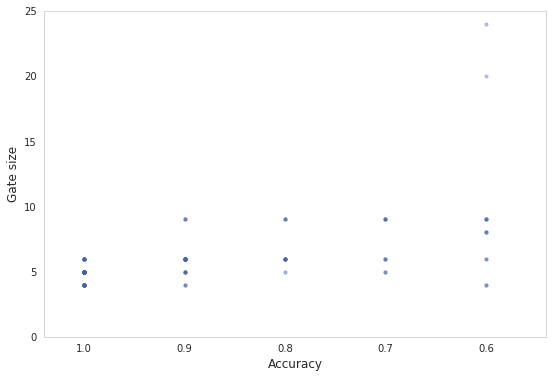

In [6]:
pop, obj_GATE, obj_ACC= [], [], []
early_stop, threshold= 0, [0.1,100]

sns.set_style("whitegrid")
plt.figure(figsize=(9,6))
plt.xlim(1.04,0.54)
plt.ylim(0,25)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Gate size", fontsize=12)
plt.grid(False)

for i in range(POPULATION):
    genes = np.random.randint(2, size=(GENE,BIT))
    pop.append(genes)
    
start_time = time()
for g in range(GENERATION):

    inputs = range(POPULATION)
    process_list= []

    q_list = [Queue() for i in range(len(inputs))]
    RESULt = []

    for i in inputs:
        process_list.append(mp.Process(target = task, args = (i, pop,  q_list[i], MODE)))
        process_list[-1].start()

    for i in inputs:
        process_list[i].join()

    for q in q_list:
        RESULt.append(q.get())
    
    end_time = time()

    FITNESS, SCORE, GATECOST, QC_R, QC_H, QC_CNOT, QC_SWAP, plt_acc, plt_gate = [], [], [], [], [], [], [], [], []
    cost_pool ,obj_gate, obj_acc = 0, 0, 0

    for i in range(POPULATION):
        SCORE.append(round(RESULt[i][0],2))
        QC_R.append(RESULt[i][1])
        QC_H.append(RESULt[i][2])
        QC_CNOT.append(RESULt[i][3])
        if MODE == "2local_swap": QC_SWAP.append(RESULt[i][4])
        
    for i in range(POPULATION):
        if MODE == "2local_swap": gcost = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: gcost = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i])
        GATECOST.append(gcost)
    
    for i in range(POOLSIZE):
        if MODE == "2local_swap": obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i])
        obj_a = SCORE[i]
        
        plt_gate.append(obj_g)
        plt_acc.append(obj_a)
        obj_gate += obj_g
        obj_acc += obj_a
    
    obj_GATE.append(obj_gate/POOLSIZE)
    obj_ACC.append(obj_acc/POOLSIZE)
    plt.scatter(plt_acc, plt_gate, s=10, c="#4863A0", alpha=(g+GENERATION/2)/(1.5*GENERATION))
    
    print("\nGeneration:", g+1,", Time:", round(end_time-start_time,2),"s")
    print("Accuracy:", SCORE)
    print("Gate cost:", GATECOST)
    
    if SCORE[0] > threshold[0] and GATECOST[0] < threshold[1]: 
        threshold = [SCORE[0],GATECOST[0]]
        early_stop = 0 
    early_stop += 1

    if g == GENERATION: break
    if early_stop == EARLYSTOP: break

    parents, t_PARETO = [], []
    for i in range(POPULATION):
        tt = [SCORE[i], GATECOST[i]]
        t_PARETO.append(tt)

    pareto_list = pareto_front(t_PARETO)
    for i in pareto_list:  
        if i not in FITNESS: FITNESS.append(i)   
#     print("Index:",FITNESS)
    
    for i in range(POOLSIZE):
        FitnessIndex = FITNESS[i]
        parents.append(pop[FitnessIndex])

    for i in range(OFFSPRINGSIZE):
        ll,rr = np.random.randint(POOLSIZE), np.random.randint(POOLSIZE) 
        parent_left, parent_right = parents[ll], parents[rr]
        cross_point = np.random.randint(GENE-1) 
        offspring = np.concatenate((parent_left[:cross_point],parent_right[cross_point:]), axis=0)

        for ii in range(PROB):
            mutation_index = np.random.randint(GENE) 
            mutation_bit = np.random.randint(BIT) 
            offspring[mutation_index][mutation_bit] = (offspring[mutation_index][mutation_bit]+1)%2

        parents.append(offspring)       
    pop = parents    
plt.show()

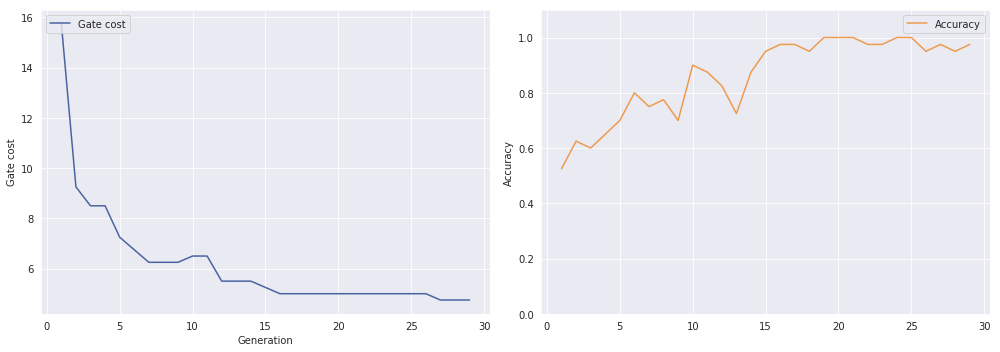

In [7]:
sns.set_style("darkgrid")
obj_x, obj_y1, obj_y2 = np.arange(len(obj_ACC)), np.array(obj_GATE), np.array(obj_ACC)
# cost_x, cost_y = np.arange(GENERATION), np.array(COST)

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax1=axes[0]
ax1.set_xlabel('Generation')
ax1.set_ylabel('Gate cost')
ax1.plot(obj_x+1, obj_y1, label="Gate cost", color="#4863A0")
ax1.tick_params(axis='y')

ax2 = axes[1]
ax1.set_xlabel('Generation')
ax2.set_ylabel('Accuracy')
ax2.plot(obj_x+1, obj_y2, label="Accuracy", color="#EE9A4D")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.1)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")


fig.tight_layout() 
plt.show()

R gate: 4 
H gate: 0 
CNOT gate: 0


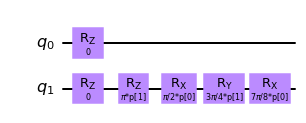

In [8]:
DISPLAY = 1
if MODE == "paper":
    qc_display, r_display, h_display, cnot_display = generate_circuit_paper(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local":
    qc_display, r_display, h_display, cnot_display = generate_circuit_2local(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local_swap":
    qc_display, r_display, h_display, cnot_display, swap_display = generate_circuit_2local_swap(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display,"\nSWAP gate:",swap_display)    
qc_display.draw(output="mpl")

In [9]:
ga_kernel = QuantumKernel(feature_map=qc_display, quantum_instance=quantum_instance,)
model_ga = SVC(kernel=ga_kernel.evaluate)
qsvm = model_ga.fit(train_x, train_y)
q_score = model_ga.score(test_x, test_y)

print(f'Test kernel acc: {q_score}')

Test kernel acc: 1.0


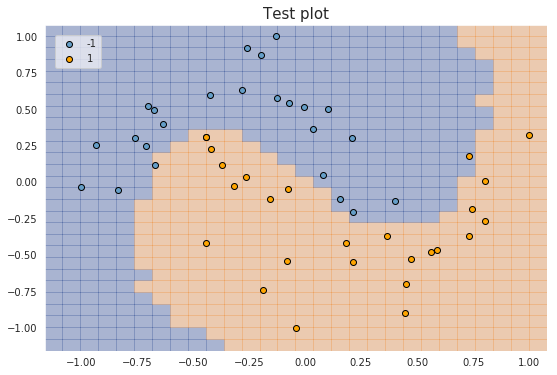

QSVM test score: 1.0
Cost time: 234.332562 s


In [10]:
margin = 0.16

def make_big_meshgrid(x, y, h=0.08): # 0.08: 28x28=784
    x_min, x_max = x.min() - margin, x.max() + margin
    y_min, y_max = y.min() - margin, y.max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = X[:, 0], X[:, 1]
bbxx, bbyy = make_big_meshgrid(X0, X1)
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))

meshgrid_time1 = time()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(9,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#659EC7",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#FFA500",
    edgecolors="k",
    label="1",)

plt.legend(loc="upper left", borderaxespad=1.0)
plt.title("Test plot", fontsize=15)
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))